In [3]:
%load_ext autoreload
%autoreload 2

In [14]:
import pandas as pd
import re
from src.nielsen_helpers import get_s3_files, process_files, get_regex_domains, weights_dataframe
from src.helpers import  plot_top, set_size
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.random  as rnd
import swifter
from datetime import timedelta
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.transforms as transforms
from matplotlib.lines import Line2D

In [5]:
# Latex Configuration
from matplotlib.patches import FancyArrowPatch
import matplotlib.font_manager as font_manager
import matplotlib.transforms as transforms
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib as mpl
import matplotlib.dates as dates
import scipy.stats 
import os

def handle_10(x):
    if "[10^{-3}]" not in x:
        return x
    x = x.replace("[10^{-3}]", "")
    
    pos = x.find("^")
    x = x + r'\times 10^{-3}'
    return x

params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': 'arial',
          'mathtext.fontset': 'cm',
          'mathtext.rm': 'serif',
    'text.usetex': False
    }

mpl.rcParams.update(params)

parlercolor = "#A50F11"
othercolor = "#377DB8"
allcolor = "#411B82"

In [42]:
df = pd.read_csv("./data/df_trends_final.csv", parse_dates=["activitydatetime"])

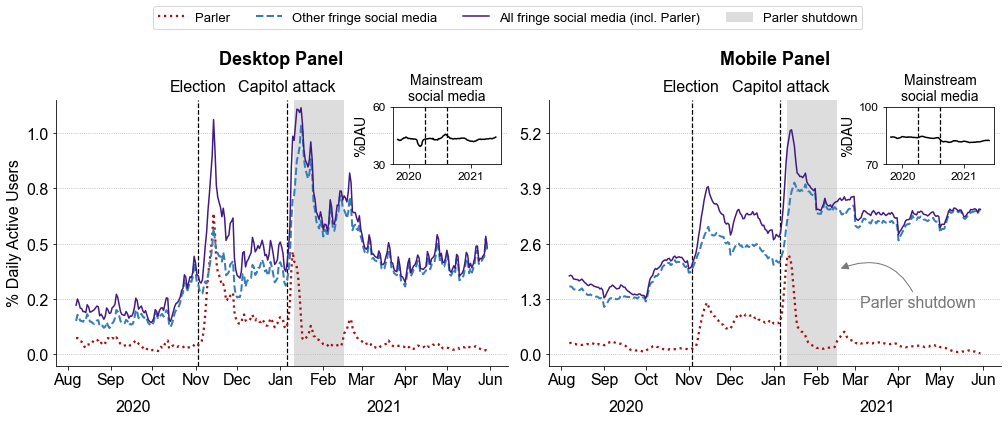

In [145]:
denom_main = lambda sumv: sumv.usersw/100
slindw_main = 7
ylabel_main = '% Daily Active Users'
annotate_coords = (2, 1.1)
pathfig = "./images/overall_br.pdf"
fmt = '%.1f'
kval = "usersw"
sept_dau=False

fontsize_caption = 13
fontsize_text = 16
fontsize_large = 18

myFmt = dates.DateFormatter('%b')
myFmtY = dates.DateFormatter('%Y')
xticks = mtick.FormatStrFormatter(fmt)

fig = plt.figure(constrained_layout=False, figsize=(14, 5.85))

axs = fig.subplot_mosaic(np.array([['desk', 'desk', 'mob', 'mob']]), 
                          gridspec_kw={ 'hspace': 1.4})

for device in ["desk", "mob"]:
    parler = df.query("device == '{}' & kind == 'is_parler'".format(device))\
        .set_index("activitydatetime").copy(deep=True)
    otherf = df.query("device == '{}' & kind == 'is_fringe_not_parler'".format(device))\
        .set_index("activitydatetime").copy(deep=True)
    allf = df.query("device == '{}' & kind == 'is_fringe'".format(device))\
        .set_index("activitydatetime").copy(deep=True)
    mainst = df.query("device == '{}' & kind == 'is_mainstream'".format(device))\
        .set_index("activitydatetime").copy(deep=True)
    allplt = df.query("device == '{}' & kind == 'all'".format(device))\
        .set_index("activitydatetime").copy(deep=True)
    
    for df_to_plot, label, color, ls, lw in zip(
        [parler, otherf, allf],
        ["Parler", "Other fringe social media", "All fringe social media (incl. Parler)"],
        [parlercolor, othercolor, allcolor],
        [":", "--", "-"],
        [2.25, 2, 1.5]
    ):
        tmp = df_to_plot["dau_w"].rolling(7, center=False).mean() / allplt["dau_w"] * 100

        axs[device].plot(tmp, 
            label=label, 
            color=color, ls=ls, lw=lw)

    if device in ["desk"]:
        axs[device].set_ylabel(ylabel_main, size=fontsize_text)
    axs[device].yaxis.grid("#C0C0C0", ls=":")
    sns.despine(ax=axs[device])

    axs[device].axvline(pd.to_datetime("2020-11-03"), color="black", ls="--", zorder=-1, lw=1.25)
    axs[device].axvline(pd.to_datetime("2021-01-06"), color="black", ls="--", zorder=-1, lw=1.25)
    plot_top(axs[device], pd.to_datetime("2021-01-06"), text="Capitol attack", size=fontsize_text, delta=-0.01)

    axs[device].xaxis.set_major_locator(dates.MonthLocator(interval=1))
    axs[device].axvspan(pd.to_datetime("2021-01-11"), pd.to_datetime("2021-02-15"), color="#DDDDDD", zorder=-2,
                  label="Parler shutdown")
    axs[device].xaxis.set_major_formatter(myFmt)
    plot_top(axs[device], pd.to_datetime("2020-09-17"), text="2020", size=fontsize_text, delta=-1.21)
    plot_top(axs[device], pd.to_datetime("2021-03-17"), text="2021", size=fontsize_text, delta=-1.21)

    axs[device].yaxis.set_major_formatter(xticks)
        
    plot_top(axs[device], pd.to_datetime("2020-11-03"), text="Election", size=fontsize_text, delta=-0.01)
    
    axs["desk"].tick_params(axis='both', which='major', labelsize=fontsize_text)
    axs["mob"].tick_params(axis='both', which='major', labelsize=fontsize_text)
    axs["desk"].set_title("Desktop Panel", pad=35, fontsize=fontsize_large, fontweight='bold')
    axs["desk"].set_ylim([-0.05, 1.15])
    axs["mob"].set_ylim([-0.26, 5.98])
    axs["desk"].set_yticks([0., 0.25, 0.5, 0.75, 1])
    axs["mob"].set_yticks([0., 1.3, 2.6, 3.9, 5.2])
    axs["mob"].set_title("Mobile Panel", pad=35, fontsize=fontsize_large, fontweight='bold')
    axs["desk"].legend(frameon=True, ncol=5, loc='upper center', bbox_to_anchor=(1, 1.375), 
                       fontsize=fontsize_caption)

    set_size(fig, (14, 5.85))
    fig.savefig(pathfig, bbox_inches="tight", dpi=300)
    fig.savefig(pathfig.replace("pdf", "png"), bbox_inches="tight",dpi=300)
    if device == "mob":
        # ANNOTATE MAIN PLOT    
        if annotate_coords is not None:
            axs[device].annotate("Parler shutdown", xy=(pd.to_datetime("2021-02-17"), annotate_coords[0]), 
                             xytext=(pd.to_datetime("2021-04-15"), annotate_coords[1]),
                             xycoords="data", annotation_clip=False, ha="center", color="#777777",
                             arrowprops={"connectionstyle": "arc3,rad=.5", 
                                         "arrowstyle": "-|>", 
                                         "color": "#777777"}, size=fontsize_text)
            
    axins = inset_axes(axs[device], width=1.5, height=0.8)
    tmp = mainst["dau_w"].rolling(14, center=False).mean() / allplt["dau_w"].rolling(14, center=False).mean() * 100
    axins.plot(tmp, 
        label=label, 
        color="black", ls=ls, lw=lw)
    axins.set_xticks([pd.to_datetime("2020-09-17"), pd.to_datetime("2021-03-17")])
    if device == "desk":
        axins.set_yticks([30, 60])
    else:
        axins.set_yticks([70, 100])

    axins.xaxis.set_major_formatter(myFmtY)
    axins.axvline(pd.to_datetime("2020-11-03"), color="black", ls="--", zorder=-1, lw=1.25)
    axins.axvline(pd.to_datetime("2021-01-06"), color="black", ls="--", zorder=-1, lw=1.25)
    axins.set_title("Mainstream\nsocial media")
    axins.set_ylabel("%DAU")
    
set_size(fig, (14, 5.85))
fig.savefig(pathfig, bbox_inches="tight", dpi=300)
fig.savefig(pathfig.replace("pdf", "png"), bbox_inches="tight",dpi=300)

In [111]:
for platform in ['8kun',
     'bitchute',
     'dlive',
     'facebook',
     'gab',
     'instagram',
     'linkedin',
     'mewe',
     'minds',
     'nextdoor',
     'parler',
     'pinterest',
     'reddit',
     'rumble',
     'snapchat',
     'telegram',
     'tiktok',
     'twitter',
     'whatsapp',
     'youtube']:
    
    axs = fig.subplot_mosaic(np.array([['desk', 'desk', 'mob', 'mob']]), 
                          gridspec_kw={ 'hspace': 1.4})

    for device in ["desk", "mob"]:
        
        mainst = df.query("device == '{}' & kind == 'is_mainstream'".format(device))\
            .set_index("activitydatetime").copy(deep=True)
        allplt = df.query("device == '{}' & kind == 'all'".format(device))\
            .set_index("activitydatetime").copy(deep=True)
        
        tmp = mainst["dau_w"].rolling(14, center=False).mean() /\
                allplt["dau_w"].rolling(14, center=False).mean() * 100
        
        axs[device].plot(tmp, 
            label=label, 
            color="black", ls=ls, lw=lw)
        axs[device].set_xticks([pd.to_datetime("2020-09-17"), pd.to_datetime("2021-03-17")])
        if device == "desk":
            axs[device].set_yticks([30, 60])
        else:
            axs[device].set_yticks([70, 100])
    plt.show()

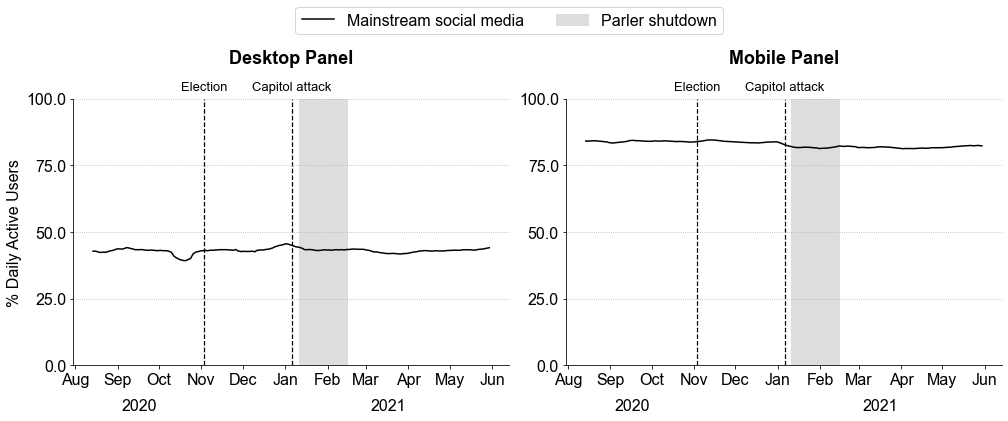

In [146]:
fig = plt.figure(constrained_layout=False, figsize=(14, 5.85))

axs = fig.subplot_mosaic(np.array([['desk', 'desk', 'mob', 'mob']]), 
                      gridspec_kw={ 'wspace': 0.3})
pathfig = "./images/extra.pdf"

for device in ["desk", "mob"]:

    mainst = df.query("device == '{}' & kind == 'is_mainstream'".format(device))\
        .set_index("activitydatetime").copy(deep=True)
    allplt = df.query("device == '{}' & kind == 'all'".format(device))\
        .set_index("activitydatetime").copy(deep=True)

    tmp = mainst["dau_w"].rolling(14, center=False).mean() /\
            allplt["dau_w"].rolling(14, center=False).mean() * 100

    axs[device].plot(tmp, 
        label="Mainstream social media", 
        color="black", ls=ls, lw=lw)
    axs[device].set_xticks([pd.to_datetime("2020-09-17"), pd.to_datetime("2021-03-17")])

    axs[device].set_yticks([0, 25, 50, 75, 100])
    
    axs["desk"].tick_params(axis='both', which='major', labelsize=fontsize_text)
    axs["mob"].tick_params(axis='both', which='major', labelsize=fontsize_text)
    axs["desk"].set_title("Desktop Panel", pad=35, fontsize=fontsize_large, fontweight='bold')
    axs["mob"].set_title("Mobile Panel", pad=35, fontsize=fontsize_large, fontweight='bold')
    axs["desk"].legend(frameon=True, ncol=5, loc='upper center', bbox_to_anchor=(1, 1.375), 
                       fontsize=fontsize_text)
    
    axs["desk"].set_ylabel(ylabel_main)
    
    if device in ["desk"]:
        axs[device].set_ylabel(ylabel_main, size=fontsize_text)
    axs[device].yaxis.grid("#C0C0C0", ls=":")
    sns.despine(ax=axs[device])

    axs[device].axvline(pd.to_datetime("2020-11-03"), color="black", ls="--", zorder=-1, lw=1.25)
    axs[device].axvline(pd.to_datetime("2021-01-06"), color="black", ls="--", zorder=-1, lw=1.25)
    plot_top(axs[device], pd.to_datetime("2021-01-06"), text="Capitol attack", size=fontsize_caption, delta=-0.01)

    axs[device].xaxis.set_major_locator(dates.MonthLocator(interval=1))
    axs[device].axvspan(pd.to_datetime("2021-01-11"), pd.to_datetime("2021-02-15"), color="#DDDDDD", zorder=-2,
                  label="Parler shutdown")
    axs[device].xaxis.set_major_formatter(myFmt)
    plot_top(axs[device], pd.to_datetime("2020-09-17"), text="2020", size=fontsize_text, delta=-1.21)
    plot_top(axs[device], pd.to_datetime("2021-03-17"), text="2021", size=fontsize_text, delta=-1.21)

    axs[device].yaxis.set_major_formatter(xticks)
        
    plot_top(axs[device], pd.to_datetime("2020-11-03"), text="Election", size=fontsize_caption, delta=-0.01)


set_size(fig, (14, 5.85))
fig.savefig(pathfig, bbox_inches="tight", dpi=300)
fig.savefig(pathfig.replace("pdf", "png"), bbox_inches="tight",dpi=300)